[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mbertani/conformal-prediction/blob/main/Inductive%20Conformal%20Predictions%20for%20Regression.ipynb)

# Inductive Conformal Prediction for Regression Tasks

This notebook contains an introductory example on Conformal Predictions for a regression task.

Original exercise taken from: https://github.com/Quilograma/ConformalPredictionTutorial/blob/main/Conformal%20Prediction.ipynb

Updated and adapted in the version below by: Filippo Remonato.

## Required packages

In [1]:
# Importing packages
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.stats import beta
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
from tqdm import tqdm
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import statsmodels.api as sm
import urllib
plt.rcParams.update({'font.size': 25})

### Conformal Prediction outline
1. Select an apriori error rate $\alpha\in (0,1)$ depending on the application and leave a calibration set that the model hasn't seen yet.
2. Define a non-conformity score function $s(x, y) \in \mathbb{R}$ that encodes a heuristic notion of uncertainty.
3. Compute $\hat{q}$ as the $\frac{\lceil{(n+1)(1-\alpha)}\rceil}{n}$ quantile of the calibration scores $s_1 = s(x_1, y_1), ..., s_n = s(x_n, y_n)$ on the calibration dataset $D_{cal}$.
4. Compute confidence intervals using $\hat{q}$ as
\begin{equation}
C(x_{val})=\{y: s(x,y)<\hat{q}\}
\end{equation}



Conformal Prediction guarantees coverage property, i.e.,
$\mathbb{P}\left(y_{val} \in C(X_{val})\right) \ge 1-\alpha$

**Assumption:** Data must be i.i.d

## Prerequisites

In [2]:
# Download the Boston dataset from the MIT open course website
urllib.request.urlretrieve("https://ocw.mit.edu/courses/15-071-the-analytics-edge-spring-2017/d4332a3056f44e1a1dec9600a31f21c8_boston.csv", "boston.csv")

('boston.csv', <http.client.HTTPMessage at 0x1858bc4a650>)

In [3]:
# Load boston housing prices dataset
df = pd.read_csv('boston.csv')
df.head()

# Each entry in the dataset corresponds to a census tract of the greater Boston area; a tract is a statistical division of an area
# LON and LAT: the longitute and latitude for the centre of the tract
# MEDV: the median value of owner-occupied hourses, in 1000 dollars (this is our target for prediction, given the other variables)
# CRIM: per-capita crime rate
# ZN: how much of the land is for large residential properties
# INDUS: proportion of the area used for industrial purposes
# CHAS: 1 if the tract is next to the Charles river, 0 if not
# NOX: concentration of Nitrous Oxide in the air
# RM: average number of rooms per dwelling
# AGE: Proportion of owner-occupied houses built before 1940
# DIS: distance of the tract to the centre of Boston
# RAD: measure of how close the tract is to important highways
# TAX: property tax rate per 10k dollars value
# PTRATION: pupil-to-teacher ratio by town in the greater Boston area

,TOWN,TRACT,LON,LAT,MEDV,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO
0,Nahant,2011,-70.955,42.2550,24.0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3
1,Swampscott,2021,-70.950,42.2875,21.6,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8
2,Swampscott,2022,-70.936,42.2830,34.7,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8
3,Marblehead,2031,-70.928,42.2930,33.4,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7
4,Marblehead,2032,-70.922,42.2980,36.2,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7


In [4]:
# Setup input (features) and output (target) datasets
target = ['MEDV']
data = [col for col in df.columns if col not in target+['TOWN']]

X = df[data]
y = df[target]

In [5]:
# Quick look at how the features dataset looks like now
X.head()

,TRACT,LON,LAT,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO
0,2011,-70.955,42.2550,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3
1,2021,-70.950,42.2875,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8
2,2022,-70.936,42.2830,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8
3,2031,-70.928,42.2930,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7
4,2032,-70.922,42.2980,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7


In [6]:
# This function calculates coverage given by the q_yhat scores we will calculate below
def calculate_coverage(lower_bound, upper_bound, y_true):
    
    out_of_bound = 0
    N = len(y_true)
    
    for i in range(N):
        if (y_true[i] < lower_bound[i]) or (y_true[i] > upper_bound[i]):
            out_of_bound = out_of_bound + 1
            
    return 1 - out_of_bound/N

In [7]:
# This function uses sklearn to setup a KNN predictor, train it, and produce predictions on a test set
def KNN_train_predict(X_train, y_train, X_test):
    
    model = make_pipeline(StandardScaler(), KNeighborsRegressor(n_neighbors=5, weights='distance'))
    model.fit(X_train, y_train)
    f = model.predict(X_test)
    
    return f, model

# This function instantiates a model and calculates the q_yhat value
def calculate_q_yhat_naive(X_train, y_train, X_cal, y_cal, alpha):
    
    f, model = KNN_train_predict(X_train, y_train, X_cal)
    N = len(y_cal)
    q_yhat = np.quantile(np.abs(y_cal-f), np.ceil((N+1)*(1-alpha))/N)
    
    return q_yhat, model

In [8]:
# Setting plotting styles common for the notebook
plt.rcParams["figure.figsize"] = (15,8)
sns.set_style("darkgrid", {'axes.grid' : True})

## Naive Inductive Conformal Prediction Regression steps

1. Train a model $f:\mathbb{R}^d \rightarrow \mathbb{R}$ on the training dataset $D_{train}$
2. Define the score function as $s(x,y)= |f(x)-y|$
3. For every $(x_i,y_i) \in D_{cal}$, compute $s_i=s(x_i,y_i)$, where $D_{cal}$ is the calibration data set.
4. Compute $\hat{q}$ as the $\frac{\left \lceil{(n_{cal}+1)(1-\alpha}\right \rceil}{n_{cal}}$ quantile of the calibration scores $s_1 = s(x_1, y_1), \ldots , s_{n_{cal}} = s(x_{n_{cal}}, y_{n_{cal}})$ on the calibration dataset.
5. Predict with $1-\alpha$ confidence as
\begin{equation}
[f(x_i)- \hat{q},f(x_i)+ \hat{q}]
\end{equation}

**Problem:** This guarantees coverage property, however, the forecast interval dimension is independent of x and its dimension is always $2\hat{q}$.




In [ ]:
# This function splits the dataset in 3 mutually exclusive datasets, train, calibatrion and evaluation (for assessement)
# NOTE: This implementation throws away the part of the dataset that goes into *_test. It could be re-implemented to not throw away that data.

def train_cal_test_split(X, y, random_state=22):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=random_state)
    
    X_cal, X_val, y_cal, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=random_state)

    return X_train, y_train, X_cal, y_cal, X_val, y_val

In [ ]:
# Apply splitting to generate the datasets

X_train, y_train, X_cal, y_cal, X_val, y_val = train_cal_test_split(X,y)

In [ ]:
## Train the model and calculate q_yhat for a level alpha using the calibration set
alpha = 0.1

q_yhat, model = calculate_q_yhat_naive(X_train, y_train, X_cal, y_cal, alpha)

print(q_yhat)

In [ ]:
# Predict values on the validation set, this is needed to calculate coverage
f_val = model.predict(X_val).flatten()

* Evaluate ICP coverage on the validation dataset. It should be greater than $1-\alpha$. Nevertheless, small deviations may happen.

In [ ]:

print('Coverage of {}'.format(calculate_coverage(f_val-q_yhat, f_val+q_yhat, y_val.values)))

In [ ]:
y_val

In [ ]:
# Plotting of the predictions and the confidence intervals calculated by our conformal prediction approach

# plt.rcParams["figure.figsize"] = (15,8)
# sns.set_style("darkgrid", {'axes.grid' : True})
ind = [i for i in range(len(y_val))]
plt.plot(ind, y_val, label='Real value')

plt.fill_between(ind, f_val-q_yhat, f_val+q_yhat, color='k', alpha=.15, label='ICP confidence interval')
plt.legend()
plt.show()

In [ ]:
# Size of the confidence interval
print(2*q_yhat)

Distribution of coverage follows the following distribution
\begin{equation}
    \mathbb{E}[1\{y \in C(x_{val})\}| \{(x_i,y_i)\}_{i=1}^{n_{cal}}] \sim  Beta(n_{cal}+1-l,l)
\end{equation}

This way, we can calculate the empirical coverage on the T (number of trials) validation sets and verify whether it follows the aforementioned beta distribution.

\begin{equation}
    C_j=\frac{1}{n_{val}} \sum_{i=1}^{n_{val}} 1_{\{y_i \in C(x_{val})\}},\qquad j \in \{1,2,...,T\}.
\end{equation}

In [ ]:
T = 10000
C_j = []

n_cal = X_cal.shape[0]
l = np.floor((n_cal+1)*(alpha))
a = n_cal + 1 - l
b = l

for j in tqdm(range(T)):
    X_train, y_train, X_cal, y_cal, X_val, y_val = train_cal_test_split(X, y, random_state=j)
    q_yhat, model = calculate_q_yhat_naive(X_train, y_train, X_cal, y_cal, alpha)
    f_val = model.predict(X_val).flatten()
    C_j.append(calculate_coverage(f_val-q_yhat, f_val+q_yhat, y_val.values))

x = np.linspace(beta.ppf(0.001, a, b), beta.ppf(0.999, a, b), T)
plt.plot(x, beta.pdf(x, a, b), label='Distribution of coverage')
plt.hist(C_j, density=True, label='Empiral coverage distribution')
plt.legend()
plt.show()
    

In [ ]:
np.mean(C_j) # should be close to 1-alpha

In [ ]:
(a)/(a+b) # real mean of beta distribution, should be close to 1-alpha, or the mean of C_j calculated above

In [ ]:
# qqplot compares the quantiles of the theoretical distribution against the sample quantiles.

rv = beta(a, b)
sm.qqplot(np.array(C_j), dist=rv, line='45')
plt.show()

# Adaptative intervals

In the previous example, the size of the interval was always equal to $2\hat{q}$.

We see now another example which uses adaptive intervals, i.e. intervals whose size depend on $x$ and the estimation of uncertainty at that particular point.

We will achieve this using _conformalized residual fitting_.

NOTE: In the original notebook (linked at the top of this document), you will find additional examples, for instance using conformalized quantile regression. 

### Conformalized Residual Fitting 

1. Train a model $f:\mathbb{R}^d \rightarrow \mathbb{R}$ on the training dataset $D_{train} = \left\{(x_i,y_i)\right\}_{i=1}^{n_{train}}$
2. Predict with model f on the first calibration set $D_{cal1}$ and store the absolute residuals $\epsilon_i=|y_i-f(x_i)|$ for every $i \in \{1,2,...,n_{cal1}\}$
3. Train a model $r:\mathbb{R}^d \rightarrow \mathbb{R}$ on $\{(x_i,\epsilon_i)\}_{i=1}^{n_{cal1}}$
2. Define the score function as $s(x,y)= \frac{|f(x)-y|}{r(x)}$
3. For every $(x_i,y_i) \in D_{cal2}$, compute $s_i=s(x_i,y_i)$, where $D_{cal2}=\left\{(x_i,y_i)\right\}_{i=1}^{n_{cal2}}$ is the second calibration dataset.
4. Compute $\hat{q}$ as the $\frac{\left \lceil{(n_{cal2}+1)(1-\alpha}\right \rceil}{n_{cal2}}$ quantile of the calibration scores $s_1 = s(x_1, y_1), ..., s_{n_{cal2}} = s(x_{n_{cal2}}, y_{n_{cal2}})$ on the second calibration dataset.
5. Predict with $1-\alpha$ confidence as
\begin{equation}
[f(x_{val})- \hat{q}r(x_{val}),f(x_{val})+ \hat{q}r(x_{val})]
\end{equation}

#### NB: Remember to re-run the "prerequisites" cells in case you are starting from this example, or have restarted the kernel

In [9]:
# first a little cleanup and housekeeping (this cell will throw an error in case you did not run the above example, because the quantities to delete do not exist. You can disregard the error in that case).
del X_train, y_train, X_cal, y_cal, X_val, y_val, model, alpha, q_yhat

NameError: name 'X_train' is not defined

In [10]:
# We define a new function to split the dataset; this version returns an extra set of calibration datasets which will be used for calculating the residuals
def train_cal_test_split2(X, y, random_state=22):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=random_state)

    X_cal, X_val, y_cal, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=random_state)

    X_cal1, X_cal2, y_cal1, y_cal2 = train_test_split(X_cal, y_cal, test_size=0.5, random_state=random_state)
    
    return X_train, y_train, X_cal1, y_cal1, X_cal2, y_cal2, X_val, y_val

In [11]:
X_train, y_train, X_cal1, y_cal1, X_cal2, y_cal2, X_val, y_val = train_cal_test_split2(X, y)

In [17]:
alpha = 0.1 # choose the error rate alpha

# create and train our model
model = make_pipeline(StandardScaler(), KNeighborsRegressor(n_neighbors=5, weights='distance'))
model.fit(X_train, y_train)

# calculate residuals on calibration 1 dataset
r_y = np.abs(y_cal1 - model.predict(X_cal1))

# fit new model residual on residuals from calibration 1 dataset
model_r = make_pipeline(StandardScaler(), KNeighborsRegressor(n_neighbors=5, weights='distance'))
model_r.fit(X_cal1, r_y)

# check for coverage without Inductive Conformal Predictions
f_val = model.predict(X_val)
f_rval = model_r.predict(X_val)
lower_bound = f_val - f_rval
upper_bound = f_val + f_rval
print('Coverage without conformal of {}'.format(calculate_coverage(lower_bound, upper_bound, y_val.values)))

# calculate q_yhat, the quantile of the calibration scores, on the calibration 2 dataset
f_cal2 = model.predict(X_cal2)
f_rcal2 = model_r.predict(X_cal2)
N = len(y_cal2)
q_yhat = np.quantile(np.abs(y_cal2-f_cal2)/f_rcal2, np.ceil((N+1)*(1-alpha))/N)
print('q_yhat value: ' + str(q_yhat))

# comparison with the naive method from the previous example
q_yhat_naive, model = calculate_q_yhat_naive(X_train, y_train, X_cal1, y_cal1, alpha)
print('q_yhat naive way: ' + str(q_yhat_naive))

# check coverage with 1-alpha confidence from the conformal predictions on the validation dataset
lower_bound = f_val - q_yhat*f_rval
upper_bound = f_val + q_yhat*f_rval
print('Coverage with conformal predictions of {}'.format(calculate_coverage(lower_bound, upper_bound, y_val.values)))

Coverage without conformal of 0.5590551181102362
q_yhat value: 2.68545795202814
q_yhat naive way: 6.721604454528558
Coverage with conformal predictions of 0.8740157480314961


In [18]:
np.mean(upper_bound-lower_bound) # average size of the intervals

16.12905762859845

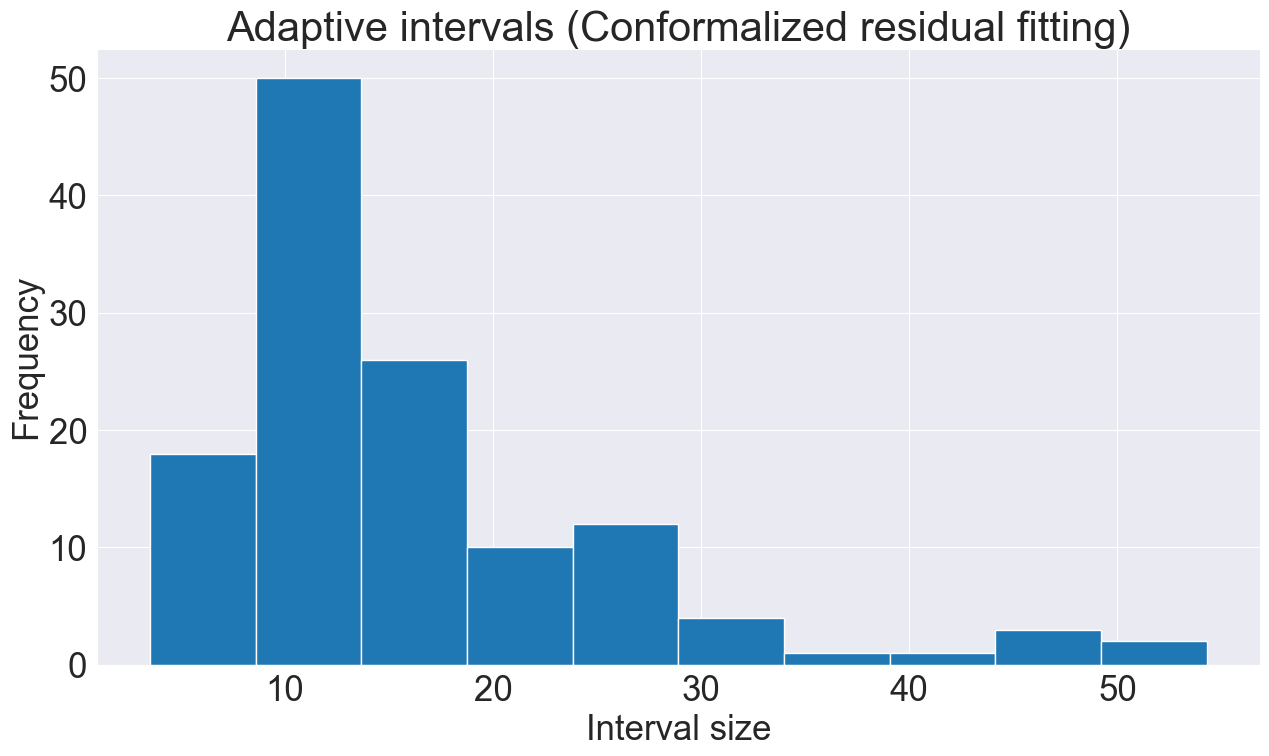

In [19]:
# histogram plot to visualise how the size of the intervals is distributed
plt.hist(np.abs(upper_bound - lower_bound))
plt.xlabel('Interval size')
plt.ylabel('Frequency')
plt.title('Adaptive intervals (Conformalized residual fitting)')
plt.show()

In [20]:
# comparison with the naive method from the previous example
q_yhat_naive, model = calculate_q_yhat_naive(X_train, y_train, X_cal1, y_cal1, alpha)
print(q_yhat_naive)

6.721604454528558


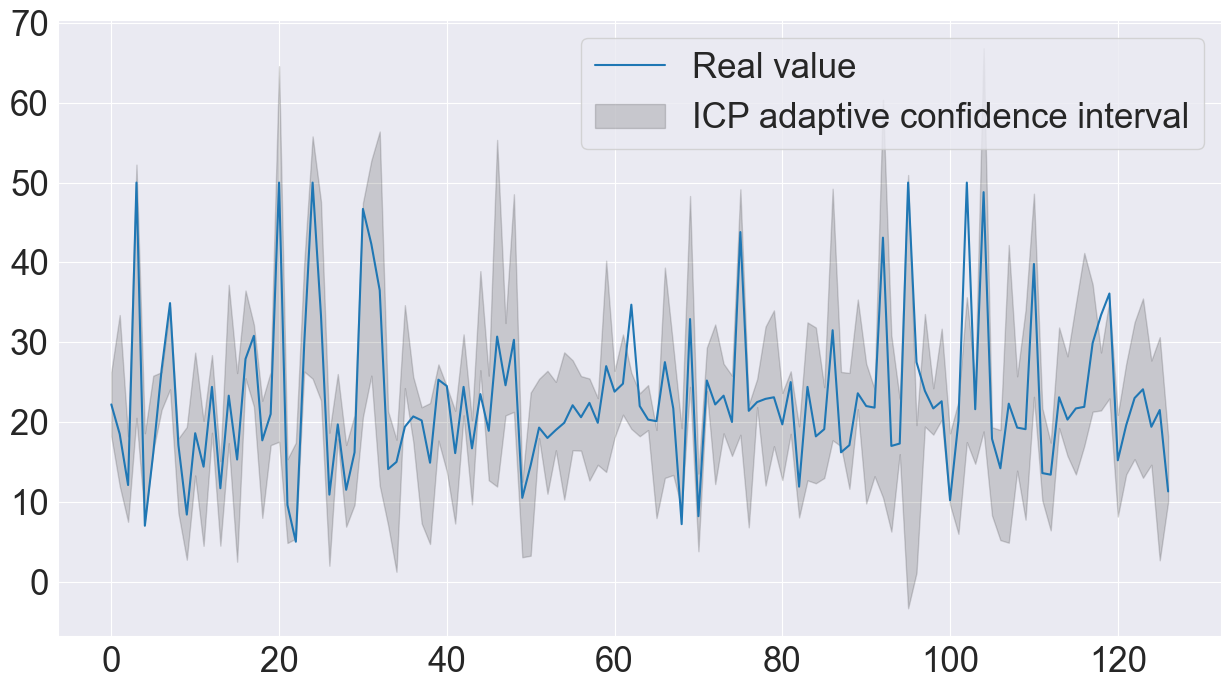

In [22]:
# Plotting of the predictions and the confidence intervals calculated by our conformal prediction approach using adaptive intervals

ind = [i for i in range(len(y_val))]
plt.plot(ind, y_val, label='Real value')

plt.fill_between(ind, lower_bound.squeeze(), upper_bound.squeeze(), color='k', alpha=.15, label='ICP adaptive confidence interval')
plt.legend()
plt.show()